In [50]:
import pandas as pd 
import numpy as np
import re
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [5]:
file_name = "../data/ICLR.cc-2023-Conference.csv"
df = pd.read_csv(file_name)

# 1. Import Necessary Libraries
# 2. Load the CSV Data
# Replace 'reviews.csv' with your actual CSV file path if different
# 3. Extract Numerical Features

# a. Define a helper function to extract numerical prefixes
def extract_numeric_prefix(s):
    """
    Extracts the leading integer from a string.
    If no integer is found, returns NaN.
    """
    match = re.match(r'^(\d+)', str(s).strip())
    return int(match.group(1)) if match else np.nan

# b. List of reviewers
reviewers = ['reviewer1', 'reviewer2', 'reviewer3', 'reviewer4']

# c. Columns to extract numeric prefixes from
prefix_columns = [
    'recommendation',
    'confidence',
    'correctness',
    'technical_novelty_and_significance',
    'empirical_novelty_and_significance'
]

# d. Extract numerical prefixes for each reviewer and specified columns
for reviewer in reviewers:
    for col in prefix_columns:
        original_col = f'{reviewer}_{col}'
        new_col = f'{reviewer}_{col}_num'
        if original_col in df.columns:
            df[new_col] = df[original_col].apply(extract_numeric_prefix)
        else:
            # If the expected column is missing, create it with NaN
            df[new_col] = np.nan

# e. Convert Date Columns to Numerical Features
# General date columns
date_columns = ['cdate', 'tmdate']

# Reviewer-specific date columns
for reviewer in reviewers:
    date_columns.extend([f'{reviewer}_cdate', f'{reviewer}_tmdate'])

for col in date_columns:
    if col in df.columns:
        # Convert to datetime, coercing errors to NaT
        df[col] = pd.to_datetime(df[col], errors='coerce')
        
        # Option 1: Convert to timestamp (seconds since epoch)
        # Handle potential NaT by filling with 0 or another placeholder
        df[f'{col}_timestamp'] = df[col].astype(np.int64) / 1e9
        df[f'{col}_timestamp'] = df[f'{col}_timestamp'].replace([np.inf, -np.inf], np.nan)
        
        # Option 2: Extract date components
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_day'] = df[col].dt.day
        df[f'{col}_hour'] = df[col].dt.hour
        df[f'{col}_minute'] = df[col].dt.minute
        df[f'{col}_second'] = df[col].dt.second

# f. Ensure Direct Numerical Columns are in Numeric Format
# For example: 'reviewer1_length', 'reviewer2_length', etc.
for reviewer in reviewers:
    length_col = f'{reviewer}_length'
    if length_col in df.columns:
        df[length_col] = pd.to_numeric(df[length_col], errors='coerce')

# 4. Handle Missing Values

# a. Identify all numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# b. Fill NaNs with the median of each numerical column
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# 5. Compute the Target Variable

# a. Extract numerical recommendation scores
recommendation_cols = [f'{reviewer}_recommendation_num' for reviewer in reviewers]

# b. Ensure recommendation columns exist
recommendation_cols = [col for col in recommendation_cols if col in df.columns]

# c. Compute variance across reviewers for each row
df['recommendation_variance'] = df[recommendation_cols].var(axis=1)
df['recommendation_difference'] = df[recommendation_cols].max(axis=1) - df[recommendation_cols].min(axis=1)

# 6. Prepare Features and Target

# a. Define target
target = 'recommendation_variance'

# b. Define feature columns
# Exclude original string columns and columns related to recommendations
excluded_columns = [
    'title', 'keywords', 'TL;DR', 'abstract', 'decision',
    'recommendation_variance'
]

# Additionally exclude original string-based reviewer columns
string_based_cols = []
for reviewer in reviewers:
    string_based_cols.extend([
        f'{reviewer}_recommendation',
        f'{reviewer}_confidence',
        f'{reviewer}_summary_of_the_paper',
        f'{reviewer}_strength_and_weaknesses',
        f'{reviewer}_clarity_quality_novelty_and_reproducibility',
        f'{reviewer}_summary_of_the_review',
        f'{reviewer}_flag_for_ethics_review',
        f'{reviewer}_cdate',
        f'{reviewer}_tmdate',
        f'{reviewer}_recommendation_num'
    ])
excluded_columns.extend(string_based_cols)

# Remove any excluded columns from numerical_cols
feature_cols = [col for col in numerical_cols if col not in excluded_columns]

feature_cols = []

for col in numerical_cols:
    if col not in excluded_columns:
        feature_cols.append(col)
        

# c. Prepare the feature matrix X and target vector y
X = df[feature_cols]
y = df[target]

/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_54594/4283018634.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_timestamp'] = df[col].astype(np.int64) / 1e9
/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_54594/4283018634.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_year'] = df[col].dt.year
/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_54594/4283018634.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

### Mean binning

In [23]:
columns_to_extract = [reviewer+'_recommendation_num' for reviewer in reviewers]
reviewer_scores_df = df[columns_to_extract]

# Create columns based on dataset statistics
df['recommendation_difference'] = reviewer_scores_df.max(axis=1) - reviewer_scores_df.min(axis=1)
df['recommendation_variance'] = reviewer_scores_df.var(axis=1)
df['recommendation_std_dev'] = reviewer_scores_df.std(axis=1)
df['recommendation_mean'] = reviewer_scores_df.mean(axis=1)

/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_54594/3657105253.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['recommendation_std_dev'] = reviewer_scores_df.std(axis=1)
/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_54594/3657105253.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['recommendation_mean'] = reviewer_scores_df.mean(axis=1)


If difference between the scores is greater than 4, this means that there is a discrepancy. If the mean is greater than 4, then they think this paper is okay maybe. I binned these values to see how many elements each group has.

In [31]:
mean_thredhold = 4
std_dev_threshold = 2

consensus_bad = df[(df['recommendation_mean'] < mean_thredhold) & (df['recommendation_std_dev'] < std_dev_threshold)]
consensus_good = df[(df['recommendation_mean'] > mean_thredhold) & (df['recommendation_std_dev'] < std_dev_threshold)]

discrepancy_bad = df[(df['recommendation_mean'] < mean_thredhold) & (df['recommendation_std_dev'] > std_dev_threshold)]
discrepancy_good = df[(df['recommendation_mean'] > mean_thredhold) & (df['recommendation_std_dev'] > std_dev_threshold)]

print("Consensus bad: ", len(consensus_bad))
print("Consensus good: ", len(consensus_good))

print("Discrepancy bad: ", len(discrepancy_bad))
print("Discrepancy good: ", len(discrepancy_good))

Consensus bad:  290
Consensus good:  2822
Discrepancy bad:  69
Discrepancy good:  489


In [36]:
mean_thredhold = 4
difference_threshold = 4

consensus_bad = df[(df['recommendation_mean'] < 4) & (df['recommendation_difference'] < 4)]
consensus_good = df[(df['recommendation_mean'] > 4) & (df['recommendation_difference'] < 4)]

discrepancy_bad = df[(df['recommendation_mean'] < 4) & (df['recommendation_difference'] >= 4)]
discrepancy_good = df[(df['recommendation_mean'] > 4) & (df['recommendation_difference'] >= 4)]

print("Consensus bad: ", len(consensus_bad))
print("Consensus good: ", len(consensus_good))

print("Discrepancy bad: ",len(discrepancy_bad))
print("Discrepancy good: ", len(discrepancy_good))

Consensus bad:  256
Consensus good:  2785
Discrepancy bad:  103
Discrepancy good:  530


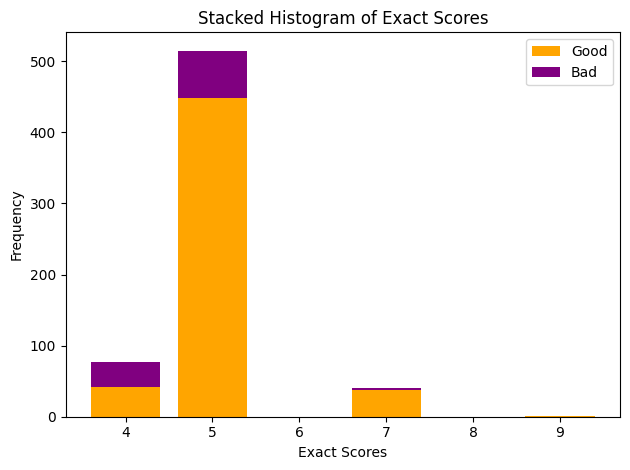

In [49]:
values = [4, 5, 6, 7, 8, 9]

# Example data (replace this with your actual data)
disc_bad = discrepancy_bad["recommendation_difference"]
disc_good = discrepancy_good["recommendation_difference"]

# Count occurrences of each score in each class
disc_bad_counts = [list(disc_bad).count(value) for value in values]
disc_good_counts = [list(disc_good).count(value) for value in values]

# Convert counts to arrays for stacking
disc_bad_counts = np.array(disc_bad_counts)
disc_good_counts = np.array(disc_good_counts)

# Create the bar chart
bar_width = 0.8
x = np.arange(len(values))  # Positions for the values

plt.bar(x, disc_good_counts, width=bar_width, label='Good', color='orange')
plt.bar(x, disc_bad_counts, width=bar_width, label='Bad', color='purple', bottom=disc_good_counts)

# Add labels, title, and legend
plt.xlabel('Exact Scores')
plt.ylabel('Frequency')
plt.title('Stacked Histogram of Exact Scores')
plt.xticks(ticks=x, labels=values)  # Replace x-axis with the exact score labels
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


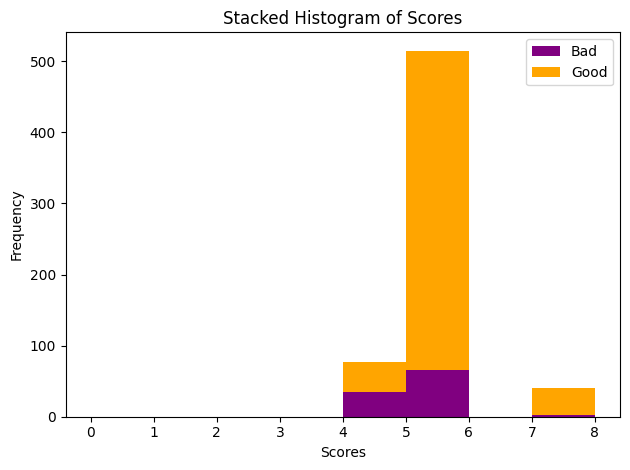

In [ ]:
# Convert to numpy arrays for stacking
disc_bad = np.array(disc_bad)
disc_good = np.array(disc_good)

# Bar width
bar_width = 0.8
bins = np.arange(0, 9, 1)  # Bins from 0 to 10
# Create the bar chart
data = [disc_bad, disc_good]

plt.hist(data, bins=bins, stacked=True, label=['Bad', 'Good'], color=['purple', 'orange'])

plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Stacked Histogram of Scores')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
